In [2]:
import torch

import utils.factories as fac
import utils.model_zoo as zoo
import utils.traintest.evaluation as ev
import utils.dataloaders.dataloading as dl
import utils.traintest.fairness as fair

import matplotlib.pyplot as plt
from importlib import reload
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
from tinydb import TinyDB
import seaborn as sns
import matplotlib.patches as patches
sns.set_theme()

db = TinyDB('evals/CelebA.json')
models = db.all()

figsize = (8,8)
marker = '+'

xlim = [0.299, 0.321]
ylim = [-0.01, 0.301]

xlabel = 'Error'
ylabel = 'Discrepancy in FNR'

box_color = 'gray'
box_alpha = 0.5

dataloader_kwargs = {'num_workers': 4, 'pin_memory': True, 'drop_last': False}

dset_in_name = "CelebA"
batch_size = 128

loader = dl.datasets_dict[dset_in_name](train=False, 
                                          batch_size=batch_size, 
                                          augmentation={}, 
                                          dataloader_kwargs=dataloader_kwargs)

In [23]:
device = torch.device('cuda:0')
all_data = []

for doc_id in range(1,37):
    model = zoo.from_database(doc_id=doc_id, dataset='CelebA', device=device)
    pareto_results = fair.return_pareto_frontier(model, loader, device)
    all_data.append(pareto_results)

concat_data = np.concatenate(all_data, 0)
# global_pareto = fair.is_pareto_efficient_simple(concat_data)

transformed_results = concat_data.copy()
transformed_results[:,0] = -transformed_results[:,0]
transformed_results[:,1] = np.abs(transformed_results[:,1])
pareto_results = concat_data[fair.is_pareto_efficient_simple(transformed_results)]
pareto_frontier = pareto_results[pareto_results[:,0].argsort()]

# Basic Plot

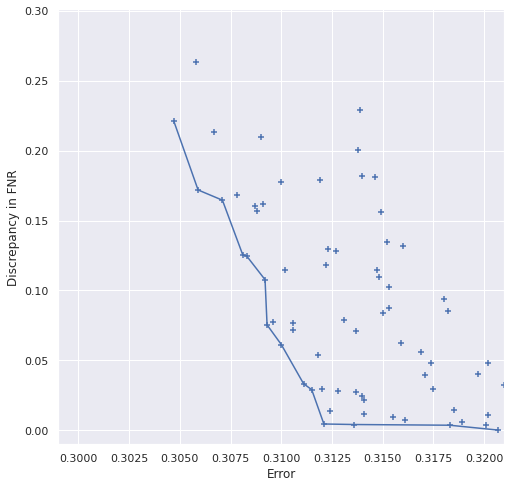

In [43]:
f = plt.figure(figsize=figsize)

plt.scatter(1-concat_data[:,0], np.abs(concat_data[:,1]), marker=marker)
plt.plot(1-pareto_frontier[:,0], np.abs(pareto_frontier[:,1]))
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

plt.savefig('imgs/fairness_frontier.png', bbox_inches='tight')

# Threshold Plot

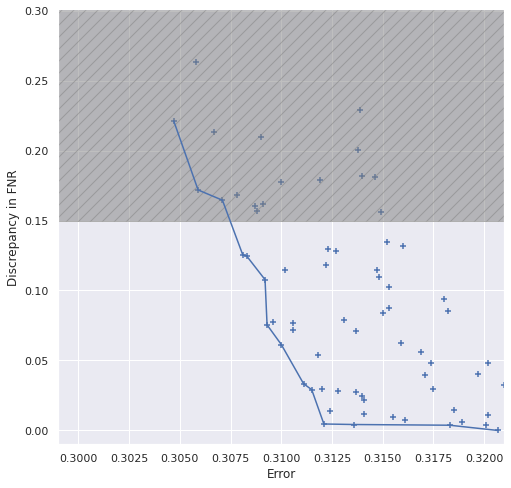

In [44]:
fig, ax = plt.subplots(figsize=figsize)

plt.scatter(1-concat_data[:,0], np.abs(concat_data[:,1]), marker=marker)
plt.plot(1-pareto_frontier[:,0], pareto_frontier[:,1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

rect = patches.Rectangle((0.0, 0.15), 1, 1, linewidth=1, edgecolor=box_color, facecolor=box_color, alpha=box_alpha, hatch=r"//")
ax.add_patch(rect)
plt.savefig('imgs/fairness_frontier_threshold.png', bbox_inches='tight')

# Weight Plot

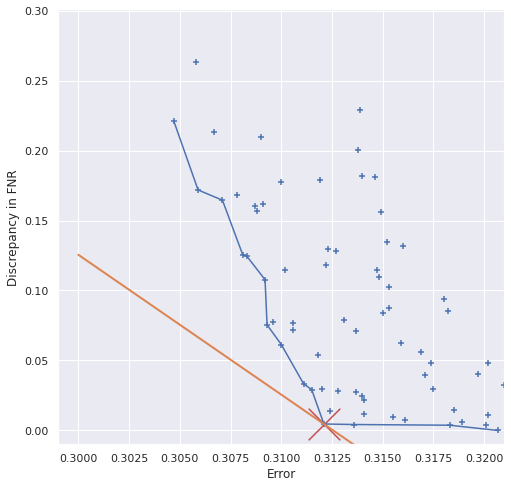

In [45]:
fig, ax = plt.subplots(figsize=figsize)

weights = np.array([1., 0.1])

intercept_idx = (weights[0]*(1-pareto_frontier[:,0]) + weights[1]*pareto_frontier[:,1]).argmin()

def tangent(x):
    value = (- weights[0] / weights[1] ) * (x + pareto_frontier[intercept_idx,0] -1) + pareto_frontier[intercept_idx,1]
    return value

plt.scatter(1-concat_data[:,0], np.abs(concat_data[:,1]), marker=marker)
plt.plot(1-pareto_frontier[:,0], pareto_frontier[:,1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

tangent_x = np.linspace(.3,.35,10)
tangent_y = tangent(tangent_x)
plt.plot(tangent_x, tangent_y, linewidth=2)
plt.scatter(1-pareto_frontier[intercept_idx,0], np.abs(pareto_frontier[intercept_idx,1]), marker='x', c='r', s=1000)

# rect = patches.Rectangle((0.0, 0.15), 1, 1, linewidth=1, edgecolor=box_color, facecolor=box_color, alpha=box_alpha, hatch=r"//")
# ax.add_patch(rect)
plt.savefig('imgs/fairness_frontier_weight.png', bbox_inches='tight')


# Combination

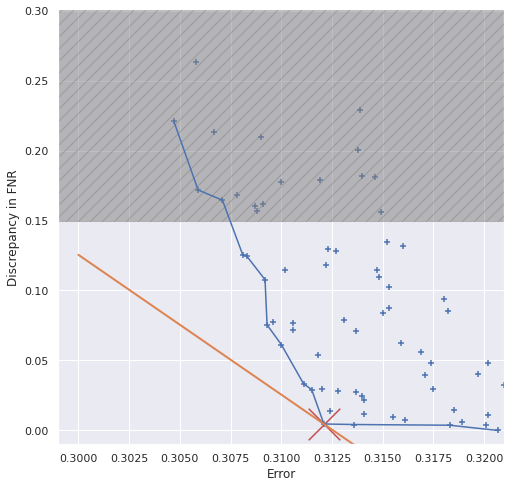

In [46]:
fig, ax = plt.subplots(figsize=figsize)

weights = np.array([1., 0.1])

intercept_idx = (weights[0]*(1-pareto_frontier[:,0]) + weights[1]*pareto_frontier[:,1]).argmin()

def tangent(x):
    value = (- weights[0] / weights[1] ) * (x + pareto_frontier[intercept_idx,0] -1) + pareto_frontier[intercept_idx,1]
    return value

plt.scatter(1-concat_data[:,0], np.abs(concat_data[:,1]), marker=marker)
plt.plot(1-pareto_frontier[:,0], pareto_frontier[:,1])
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(xlim)
plt.ylim(ylim)

tangent_x = np.linspace(.3,.35,10)
tangent_y = tangent(tangent_x)
plt.plot(tangent_x, tangent_y, linewidth=2)
plt.scatter(1-pareto_frontier[intercept_idx,0], np.abs(pareto_frontier[intercept_idx,1]), marker='x', c='r', s=1000)

rect = patches.Rectangle((0.0, 0.15), 1, 1, linewidth=1, edgecolor=box_color, facecolor=box_color, alpha=box_alpha, hatch=r"//")
ax.add_patch(rect)

# plt.savefig('fairness_frontier_combination.png', bbox_inches='tight')


# Adversarial Robustness

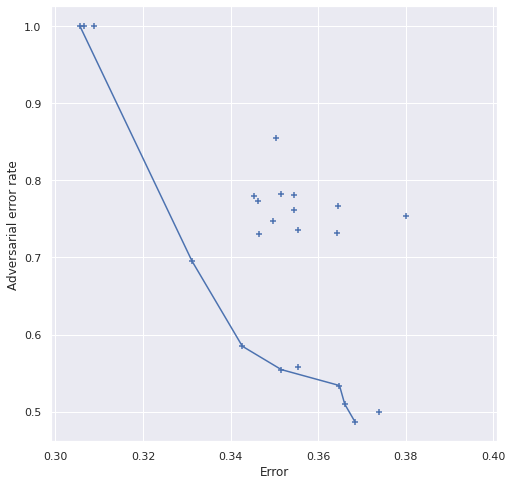

In [50]:
results = []
for model_id in range(1, 29):
    model = models[model_id]
    results.append([model['results']['acc'], model['results']['Adversarial']['Linf_0.01']])
results = np.array(results)

transformed_results = results.copy()
transformed_results[:,0] = -transformed_results[:,0]
transformed_results[:,1] = -transformed_results[:,1]
pareto_results = results[fair.is_pareto_efficient_simple(transformed_results)]
pareto_frontier = pareto_results[pareto_results[:,0].argsort()]

figure = plt.figure(figsize=figsize)
# plt.scatter(1-a[:,0], np.abs(a[:,1]))
plt.scatter(1-results[:,0], 1-results[:,1], marker=marker)
plt.xlim([0.299,.401])
# plt.ylabel("Acceptance rate disparity")
plt.xlabel(xlabel)
plt.ylabel("Adversarial error rate") # Linf eps=0.01 
plt.plot(1-pareto_frontier[:,0], 1-pareto_frontier[:,1])
plt.savefig('imgs/robustness_frontier.png', bbox_inches='tight')

# Tri-dimensional Plot

In [51]:
results = []
models = db.all()
for model_id in range(0, 36):
    # print(model_id)
    model = models[model_id]
    if model['results']['acc']>.6:
        results.append([model['results']['acc'], model['results']['Adversarial']['Linf_0.01'], model['results']['Fairness']['Difference']['fnr']])
results = np.array(results)

transformed_results = results.copy()
transformed_results[:,0] = -transformed_results[:,0]
transformed_results[:,1] = -transformed_results[:,1]
transformed_results[:,2] = np.abs(transformed_results[:,2])
pareto_results = results[fair.is_pareto_efficient_simple(transformed_results)]

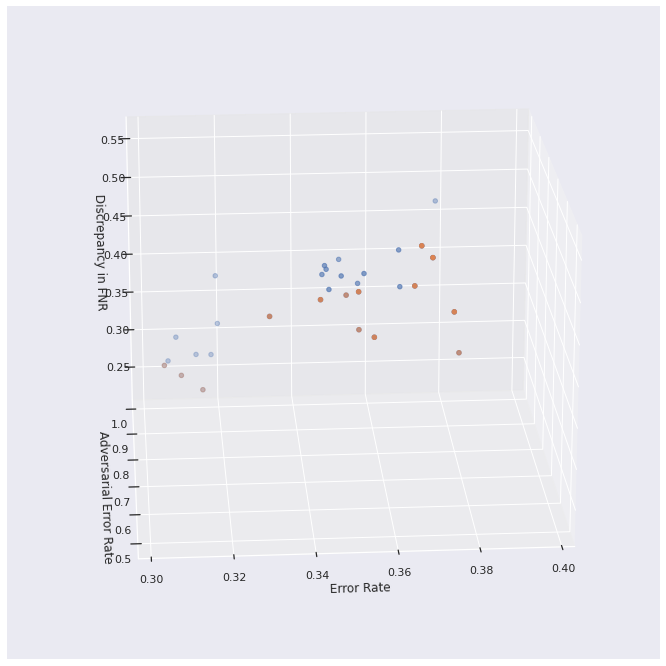

In [52]:
# %matplotlib widget
import matplotlib.pyplot as plt
import random
from matplotlib import animation

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

sequence_containing_x_vals = 1-results[:,0]
sequence_containing_y_vals = 1-results[:,1]
sequence_containing_z_vals = np.abs(results[:,2])
ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals)

pareto_x = 1-pareto_results[:,0]
pareto_y = 1-pareto_results[:,1]
pareto_z = np.abs(pareto_results)[:,2]
ax.scatter(pareto_x, pareto_y, pareto_z)

ax.set_xlabel('Error Rate')
ax.set_xlim3d([0.299,.401])

ax.set_ylabel('Adversarial Error Rate')
ax.set_zlabel(ylabel)

slow_down_factor = 1.5
N = int(90*slow_down_factor)-5

def update(num):  
    ax.view_init(elev=20., azim=180+num/slow_down_factor)

ani = animation.FuncAnimation(fig, update, N, interval=100/N, blit=False)
ani.save('imgs/tradeoffs_3D.gif', writer='imagemagick')
plt.show()